<a href="https://colab.research.google.com/github/SandeepGandham4/CardioVascularDetection/blob/main/Copy_of_CAD_using_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = "sandeepgandham45"
os.environ['KAGGLE_KEY'] = "b06ed15a34d9e498c4ab5e7a8b67f7ed"


In [4]:
!pip install kaggle

!kaggle datasets download -d danialsharifrazi/cad-cardiac-mri-dataset



import zipfile

import os

import cv2

import numpy as np

import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout

from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

Dataset URL: https://www.kaggle.com/datasets/danialsharifrazi/cad-cardiac-mri-dataset
License(s): unknown


In [5]:
!unzip -o cad-cardiac-mri-dataset.zip -d ./cad_cardiac_mri


Streaming output truncated to the last 5000 lines.
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_57/IM00059.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_57/IM00060.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_58/IM00001.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_58/IM00002.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_58/IM00003.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_58/IM00004.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_58/IM00005.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_58/IM00006.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_58/IM00007.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_58/IM00008.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_58/IM00009.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_58/IM00010.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_58/IM00011.jpg  
  inflating: ./cad_cardiac_mri/Sick/Directory_26/SR_

In [6]:
import os
os.listdir("./cad_cardiac_mri")


['Sick', 'Normal', 'Author Bios.docx']

In [7]:
import os
import zipfile
import cv2
import numpy as np

# Define the main directory path
main_dir = '/content/cad_cardiac_mri'

# Lists to store images
normal_images = []
sick_images = []

# Iterate through dataset directories
for category in os.listdir(main_dir):
    category_path = os.path.join(main_dir, category)

    if os.path.isdir(category_path):  # Ensure it's a directory
        for subdir, _, files in os.walk(category_path):
            for file in files:
                file_path = os.path.join(subdir, file)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:  # Check if the image was read properly
                    img = cv2.resize(img, (128, 128))  # Resize to 128x128

                    if 'normal' in category.lower():
                        normal_images.append(img)
                    elif 'sick' in category.lower():
                        sick_images.append(img)

# Convert to numpy arrays
normal_images = np.array(normal_images)
sick_images = np.array(sick_images)

print("Loaded normal images:", normal_images.shape)
print("Loaded sick images:", sick_images.shape)


Loaded normal images: (37564, 128, 128)
Loaded sick images: (25861, 128, 128)


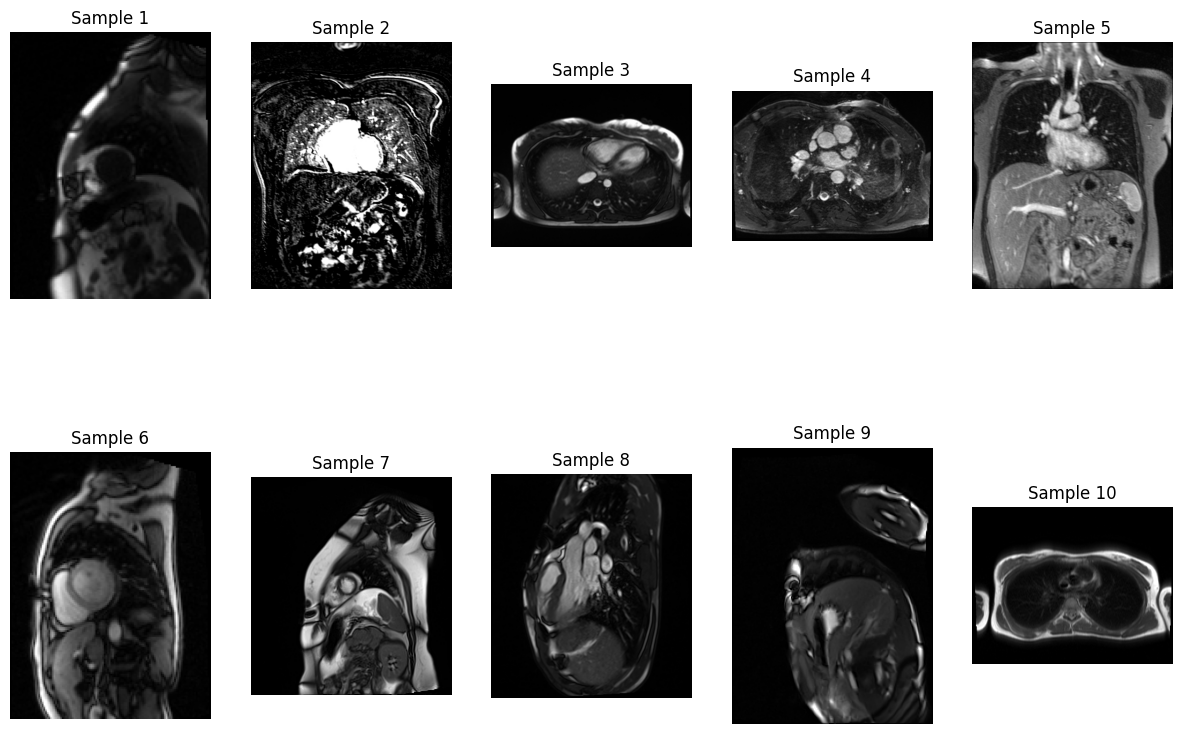

In [8]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Define dataset path (Make sure it's correctly extracted in /content/)
dataset_path = "/content/cad_cardiac_mri"

# Collect all image file paths
image_paths = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure it's an image
            image_paths.append(os.path.join(root, file))

# Select 10 random images
sample_images = random.sample(image_paths, 10)

# Function to display images
def display_images(image_paths):
    plt.figure(figsize=(15, 10))  # Adjust figure size
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(image_path)  # Load image
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        plt.subplot(2, 5, i + 1)  # Create subplot (2 row, 5 columns)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Sample {i+1}")

    plt.show()

# Display 10 images
display_images(sample_images)


In [9]:
def load_image_sequences(main_dir, label, num_sequences=10, time_steps=10, img_size=(128, 128)):
    sequences = []
    labels = []
    count = 0

    for category in os.listdir(main_dir):
        if count >= num_sequences:
            break

        category_path = os.path.join(main_dir, category)

        if os.path.isdir(category_path) and label.lower() in category.lower():
            sequence = []
            image_files = []

            # Collect all image paths inside the category
            for subdir, _, files in os.walk(category_path):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_files.append(os.path.join(subdir, file))

            # Sort images to maintain temporal order
            image_files = sorted(image_files)[:time_steps]

            # Load images
            for file_path in image_files:
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, img_size) / 255.0  # Normalize
                sequence.append(img)

            # Only append sequences with exact time_steps
            if len(sequence) == time_steps:
                sequences.append(np.array(sequence))
                labels.append(1 if label == "sick" else 0)
                count += 1  # Increment only if sequence is valid

    return np.array(sequences), np.array(labels)

# Load sequences
normal_sequences, normal_labels = load_image_sequences(main_dir, label="normal", num_sequences=10)
sick_sequences, sick_labels = load_image_sequences(main_dir, label="sick", num_sequences=10)

# Combine and shuffle
X = np.concatenate((normal_sequences, sick_sequences), axis=0)
y = np.concatenate((normal_labels, sick_labels), axis=0)

# Shuffle the dataset
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

# Print dataset shape
print("Dataset Shape:", X.shape)
print("Labels Shape:", y.shape)


Dataset Shape: (2, 10, 128, 128)
Labels Shape: (2,)


In [10]:
# Define the number of time steps
TIME_STEPS = 10

# Reshape for CNN-LSTM input
X = X.reshape(-1, TIME_STEPS, 128, 128, 1)

# Verify shape
print("Final dataset shape:", X.shape)


Final dataset shape: (2, 10, 128, 128, 1)


In [11]:
import os
import cv2
import numpy as np

def load_image_sequences(main_dir, label):
    sequences = []
    labels = []

    # Define the full path for the 'Normal' or 'Sick' category
    category_path = os.path.join(main_dir, label)

    # Check if the category directory exists
    if not os.path.exists(category_path):
        print(f"Directory does not exist: {category_path}")
        return np.array(sequences), np.array(labels)

    # Walk through the directory and subdirectories
    for subdir, _, files in os.walk(category_path):
        for file in files:
            file_path = os.path.join(subdir, file)

            # Check if the file is an image (handle common formats)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    img = cv2.resize(img, (128, 128))  # Resize to match the model input
                    sequences.append(img[..., np.newaxis])  # Add channel dimension (to match CNN input)
                    labels.append(1 if label.lower() == "sick" else 0)  # Assign labels

    # Debug: Print the count of images loaded
    print(f"Loaded {len(sequences)} images for label: {label}")

    return np.array(sequences), np.array(labels)

# Example Usage
main_dir = '/content/cad_cardiac_mri'  # Your dataset path
normal_sequences, normal_labels = load_image_sequences(main_dir, "Normal")
sick_sequences, sick_labels = load_image_sequences(main_dir, "Sick")

# Combine for training
X = np.concatenate((normal_sequences, sick_sequences), axis=0)
y = np.concatenate((normal_labels, sick_labels), axis=0)

# Verify the shape
print("X shape:", X.shape)  # Expected: (number of images, 128, 128, 1)
print("y shape:", y.shape)  # Expected: (number of images,)


Loaded 37564 images for label: Normal
Loaded 25861 images for label: Sick
X shape: (63425, 128, 128, 1)
y shape: (63425,)


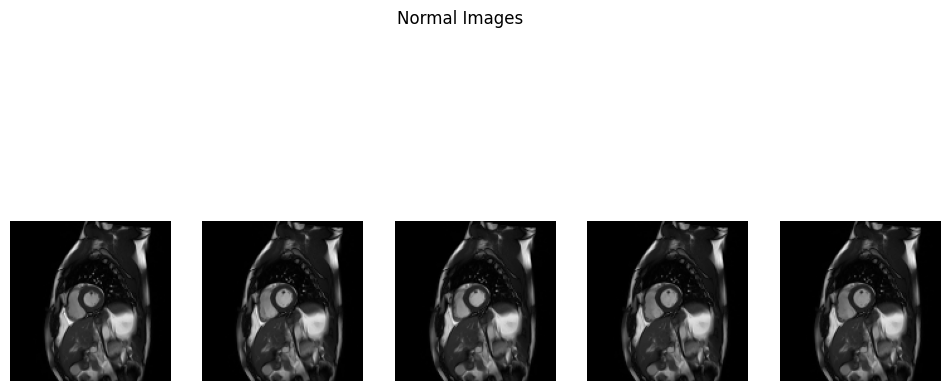

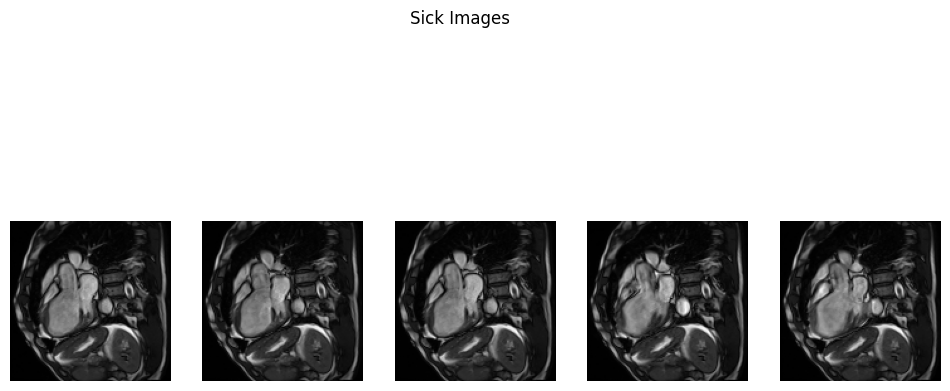

In [12]:
import matplotlib.pyplot as plt

# Function to display a few images
def display_images(images, title):
    plt.figure(figsize=(12, 6))

    for i in range(min(len(images), 5)):  # Show up to 5 images
        img = images[i, :, :, 0]  # Select the image (height, width) from the 4D array
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# After loading images, display a few
display_images(normal_sequences, 'Normal Images')
display_images(sick_sequences, 'Sick Images')


In [13]:
def load_image_sequences(main_dir, label, num_sequences=10):

    sequences = []
    labels = []

    category_path = os.path.join(main_dir, label)

    # Check if category directory exists
    if not os.path.exists(category_path):
        print(f"Directory does not exist: {category_path}")
        return np.array(sequences), np.array(labels)

    image_files = os.listdir(category_path)

    # Debug: Print the number of files found and their names
    print(f"Found {len(image_files)} images in {label} category.")
    print("All files found in category:", image_files)

    count = 0

    for file in image_files:
        file_path = os.path.join(category_path, file)

        # Check if the file is an image
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize to match the model input
                sequences.append(img)
                labels.append(0 if label == "Normal" else 1)  # 0 for Normal, 1 for Sick
                count += 1

            # Stop if we reached the desired number of sequences
            if count >= num_sequences:
                break

    # Debug: Print the count of images loaded
    print(f"Loaded {count} images for label: {label}")

    return np.array(sequences), np.array(labels)

# Load images
normal_sequences, normal_labels = load_image_sequences(main_dir, 'Normal', num_sequences=10)
sick_sequences, sick_labels = load_image_sequences(main_dir, 'Sick', num_sequences=10)

# Check shapes of loaded sequences
print("Normal sequences shape:", normal_sequences.shape)
print("Sick sequences shape:", sick_sequences.shape)


Found 16 images in Normal category.
All files found in category: ['Directory_8', 'Directory_16', 'Directory_2', 'Directory_15', 'Directory_9', 'Directory_12', 'Directory_6', 'Directory_11', 'Directory_3', 'Directory_10', 'Directory_13', 'Directory_1', 'Directory_7', 'Directory_5', 'Directory_4', 'Directory_14']
Loaded 0 images for label: Normal
Found 14 images in Sick category.
All files found in category: ['Directory_25', 'Directory_22', 'Directory_23', 'Directory_26', 'Directory_29', 'Directory_21', 'Directory_27', 'Directory_19', 'Directory_28', 'Directory_18', 'Directory_20', 'Directory_24', 'Directory_30', 'Directory_17']
Loaded 0 images for label: Sick
Normal sequences shape: (0,)
Sick sequences shape: (0,)


In [14]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_image_sequences(main_dir, label, time_steps=10, num_sequences=500):
    sequences = []
    labels = []

    category_path = os.path.join(main_dir, label)

    # Check if category directory exists
    if not os.path.exists(category_path):
        print(f"Directory does not exist: {category_path}")
        return np.array(sequences), np.array(labels)

    count = 0
    images_in_sequence = []

    # Traverse through subdirectories
    for subdir, _, files in os.walk(category_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            # Check if the file is an image
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (128, 128))  # Resize to match the model input

                    images_in_sequence.append(img)

                    # Once we have enough images for a sequence
                    if len(images_in_sequence) == time_steps:
                        sequences.append(np.array(images_in_sequence))  # Add sequence
                        labels.append(0 if label == 'Normal' else 1)  # Assign label (0 for Normal, 1 for Sick)

                        # Reset for next sequence
                        images_in_sequence = []

                        count += 1
                    if count >= num_sequences:
                        break
        if count >= num_sequences:
            break

    print(f"Loaded {count} sequences for label: {label}")

    return np.array(sequences), np.array(labels)

# Load images
main_dir = '/content/cad_cardiac_mri'  # Replace with your main directory path
normal_sequences, normal_labels = load_image_sequences(main_dir, 'Normal', time_steps=10, num_sequences=500)
sick_sequences, sick_labels = load_image_sequences(main_dir, 'Sick', time_steps=10, num_sequences=500)

# Check shapes of loaded sequences
print("Normal sequences shape:", normal_sequences.shape)
print("Sick sequences shape:", sick_sequences.shape)

# Combine normal and sick sequences
X = np.concatenate((normal_sequences, sick_sequences), axis=0)  # Shape: (num_sequences, TIME_STEPS, 128, 128, 1)
y = np.array([0] * len(normal_sequences) + [1] * len(sick_sequences))  # Labels: 0 for Normal, 1 for Sick

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)


Loaded 500 sequences for label: Normal
Loaded 500 sequences for label: Sick
Normal sequences shape: (500, 10, 128, 128)
Sick sequences shape: (500, 10, 128, 128)
Training data shape: (800, 10, 128, 128)
Validation data shape: (200, 10, 128, 128)
Training labels shape: (800,)
Validation labels shape: (200,)


In [15]:
from tensorflow.keras import layers, models

# Define the CNN-LSTM model using TimeDistributed
model = models.Sequential()

# Ensure input_shape is correctly defined (TimeSteps, Height, Width, Channels)
model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
                                 input_shape=(10, 128, 128, 1)))  # 10 frames
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')))

# TimeDistributed Flatten
model.add(layers.TimeDistributed(layers.Flatten()))

# LSTM layer needs (batch, time_steps, features), so keep the time dimension
model.add(layers.LSTM(64, activation='relu', return_sequences=False))

# Output layer for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to verify architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_6 (TimeDistributed) │ (None, 10, 128, 128, 32)    │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 10, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 10, 64, 64, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 10, 32, 32, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 10, 32, 32, 64)      │          36,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 10, 65536)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │      16,793,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,849,665 (64.28 MB)

 Trainable params: 16,849,665 (64.28 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Fit the model

history = model.fit(X_train, y_train,

                    validation_data=(X_val, y_val),

                    epochs=10,  # Adjust the number of epochs as needed

                    batch_size=16)  # You may want to adjust the batch size based on your system capacity


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 740s 15s/step - accuracy: 0.5130 - loss: 346.5236 - val_accuracy: 0.4350 - val_loss: 15.0395
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 698s 14s/step - accuracy: 0.6355 - loss: 5.2979 - val_accuracy: 0.7850 - val_loss: 1.2435
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 695s 14s/step - accuracy: 0.8243 - loss: 1.3608 - val_accuracy: 0.8950 - val_loss: 0.5597
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 761s 14s/step - accuracy: 0.9122 - loss: 0.4921 - val_accuracy: 0.9050 - val_loss: 0.3644
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 743s 14s/step - accuracy: 0.9395 - loss: 0.4057 - val_accuracy: 0.9350 - val_loss: 0.2702
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 696s 14s/step - accuracy: 0.9583 - loss: 0.1847 - val_accuracy: 0.9500 - val_loss: 0.2264
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 761s 14s/step - accuracy: 0.9826 - loss: 0.1294 - val_accuracy: 0.8700 - val_loss: 2.2280
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 735s 14s/step - accuracy: 0.9532 - loss: 0.1486 - val_accuracy:

In [18]:
model.save('my_model.keras')

In [19]:
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, f1_score

# Make predictions on the validation data
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes (0 or 1)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_classes)
print("Accuracy:", accuracy)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val, y_pred)
print("Mean Absolute Error:", mae)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_val, y_pred_classes)
recall = recall_score(y_val, y_pred_classes)
f1 = f1_score(y_val, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step
Accuracy: 0.945
Mean Absolute Error: 0.058716244995594025
Precision: 0.9428571428571428
Recall: 0.9519230769230769
F1 Score: 0.9473684210526315


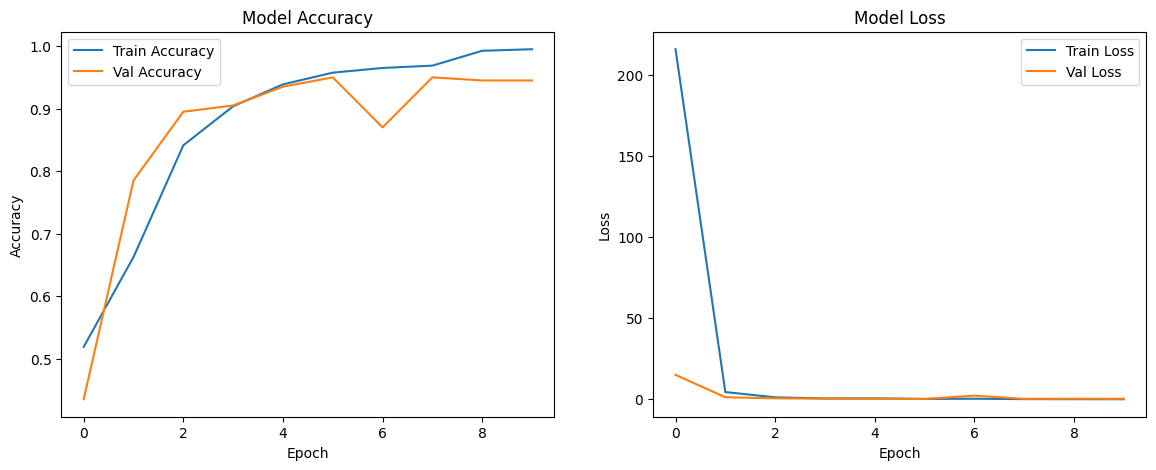

In [20]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(14, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history.get('accuracy', []), label='Train Accuracy')  # Handle different naming conventions
plt.plot(history.history.get('val_accuracy', []), label='Val Accuracy')  # Handle different naming conventions
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history.get('loss', []), label='Train Loss')  # Handle different naming conventions
plt.plot(history.history.get('val_loss', []), label='Val Loss')  # Handle different naming conventions
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Show the plots
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step


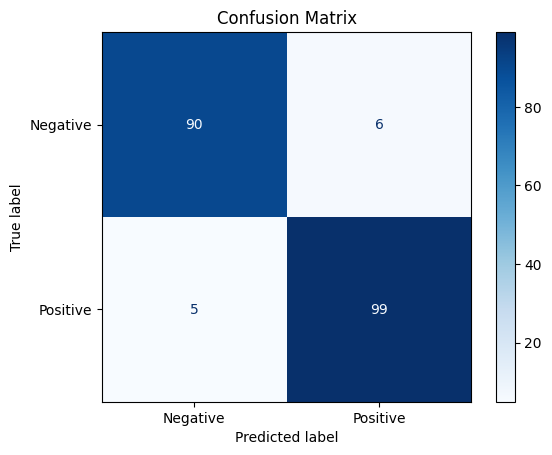

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Display confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues, values_format="d")  # Use 'd' for integer values

# Add title
plt.title("Confusion Matrix")
plt.show()


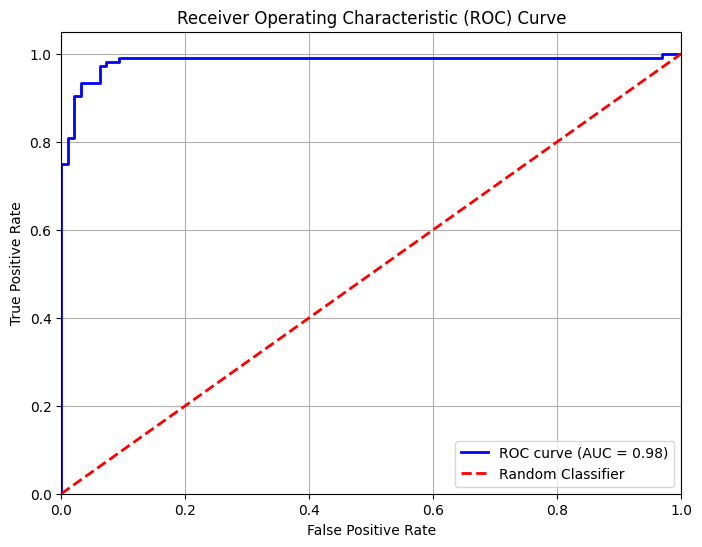

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred)  # Use raw probabilities (not classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Show plot
plt.show()


Saving IM00001.jpg to IM00001 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


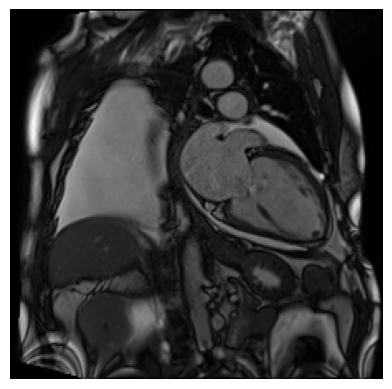

Prediction: 🚨 Disease Detected!


In [59]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

# Load the trained model
model = tf.keras.models.load_model('/content/my_model.keras')  # Update the path if needed

# Upload image
uploaded = files.upload()

# Get the uploaded file name
image_path = list(uploaded.keys())[0]

# Load and preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((128, 128))  # Resize to model input size
    img = np.array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add time step dimension (for LSTM input)
    return img

# Preprocess the uploaded image
processed_img = preprocess_image(image_path)

# Make prediction
prediction = model.predict(processed_img)

# Display the image
plt.imshow(Image.open(image_path), cmap='gray')
plt.axis('off')
plt.show()

# Show the result
if prediction[0][0] > 0.5:
    print("Prediction: 🚨 Disease Detected!")
else:
    print("Prediction: ✅ Normal")


Saving s2.jpg to s2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


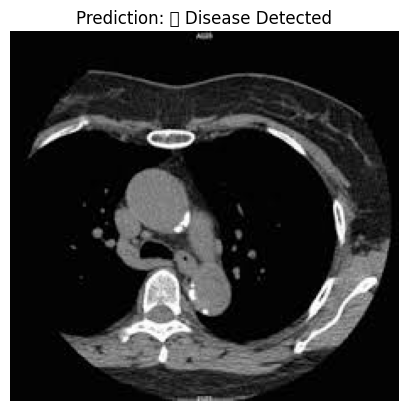

🖼️ Image: s2.jpg
📊 Prediction Score: 0.5131
🎯 Final Prediction: 🚨 Disease Detected



In [66]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

# Load the trained model
model_path = "/content/my_model.keras"  # Adjust path if needed
model = tf.keras.models.load_model(model_path)

# Upload images
uploaded_files = files.upload()

# Define class labels
class_names = ["✅ Normal", "🚨 Disease Detected"]

# Function to preprocess images
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((128, 128))  # Resize to match model input
    img = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values

    # Add required dimensions for CNN-LSTM
    img = np.expand_dims(img, axis=-1)  # (128, 128, 1)
    img = np.expand_dims(img, axis=0)  # (1, 128, 128, 1)
    img = np.repeat(img, 10, axis=0)  # Simulate a sequence (10 time steps)
    img = np.expand_dims(img, axis=0)  # (1, 10, 128, 128, 1)

    return img

# Process and predict each image
for image_name in uploaded_files.keys():
    processed_img = preprocess_image(image_name)
    prediction = model.predict(processed_img)

    predicted_class = int(prediction[0][0] >= 0.50)  # Adjust threshold if needed

    # Display the image
    img = Image.open(image_name)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Prediction: {class_names[predicted_class]}")
    plt.show()

    # Print raw results
    print(f"🖼️ Image: {image_name}")
    print(f"📊 Prediction Score: {prediction[0][0]:.4f}")
    print(f"🎯 Final Prediction: {class_names[predicted_class]}\n")
